<a href="https://colab.research.google.com/github/ilyunjung/CyberSecurityCapstoneDesign/blob/main/Deepfool_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **deepfool**

gradient 계산이 아닌 여러 개의 점에서 decision boundary에 대해 수직으로 투영하고 적당한 노이즈를
추가하여 적대적 사례를 만드는 방법

In [4]:
from keras.datasets import cifar10
import tensorflow as tf
from tensorflow.keras.layers import Flatten
import numpy as np
from keras.utils import to_categorical 
from sklearn.utils import shuffle
import os
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


Lenet 구현
데이터 전처리

In [2]:
def pre_data():
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()

  x_train = x_train / 255.
  x_test = x_test / 255.

  y_train = to_categorical(y_train, 10,dtype='float32')
  y_test = to_categorical(y_test, 10,dtype='float32')  

  return x_train, y_train, x_test, y_test

Classifier 생성

In [5]:
def init_weight(shape):
  w = tf.truncated_normal(shape = shape, stddev = 0.1)
  return tf.Variable(w)

def init_bias(shape):
  b = tf.zeros(shape)
  return tf.Variable(b)
  
def CNN_classifier(x):

  conv1_w = init_weight((5,5,3,64))
  conv1_b = init_bias(64)
  conv1 = tf.nn.conv2d(x,conv1_w, strides = [1,1,1,1], padding = 'SAME') + conv1_b
  conv1 = tf.nn.relu(conv1)

  conv1 = tf.nn.max_pool2d(conv1,ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')

  conv2_w = init_weight((5,5,64,64))
  conv2_b = init_bias(64)
  conv2 = tf.nn.conv2d(conv1,conv2_w, strides = [1,1,1,1], padding = "SAME") + conv2_b
  conv2 = tf.nn.relu(conv2)

  conv2 = tf.nn.max_pool2d(conv2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = "SAME")

  conv3_w = init_weight((5,5,64,64))
  conv3_b = init_bias(64)
  conv3 = tf.nn.conv2d(conv2,conv3_w, strides = [1,1,1,1], padding = "SAME") + conv3_b
  conv3 = tf.nn.relu(conv3)

  conv3 = tf.nn.max_pool2d(conv3, ksize = [1,2,2,1], strides = [1,2,2,1], padding = "SAME")

  fc0 = Flatten()(conv3)

  fc1_w = init_weight((1024,120))
  fc1_b = init_bias(120)
  fc1 = tf.matmul(fc0,fc1_w) + fc1_b
  fc1 = tf.nn.relu(fc1)

  fc2_w = init_weight((120,84))
  fc2_b = init_bias(84)
  fc2 = tf.matmul(fc1,fc2_w) + fc2_b
  fc2 = tf.nn.relu(fc2)

  fc3_w = init_weight((84,10))
  fc3_b = init_bias(10)
  fc3 = tf.add(tf.matmul(fc2,fc3_w),fc3_b, name = 'last_layer')
  output = tf.nn.softmax(fc3, name = 'logits')
  
  return output
  
x_train, y_train, x_test, y_test = pre_data()
x_train, y_train = shuffle(x_train, y_train)

EPOCHS = 15
BATCH_SIZE = 128

x = tf.placeholder(tf.float32, (None,32,32,3), name = 'x')
y = tf.placeholder(tf.float32, (None,10), name = 'y')

logits = CNN_classifier(x)
loss_operation = tf.reduce_mean(-tf.reduce_sum(y * tf.log(logits), 1))

train_operation = tf.train.AdamOptimizer(1e-3).minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, axis = 1),tf.argmax(y, axis =1), name = 'correct_prediction')
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = 'accuracy_operation')
saver = tf.train.Saver()

Classifier 훈련

In [6]:
persisted_sess = tf.Session()
print (tf.global_variables())
persisted_sess.run(tf.global_variables_initializer())

num_examples = len(x_train)

print('Training...')

for i in range(EPOCHS):
  x_train, y_train = shuffle(x_train, y_train)

  for offset in range(0,num_examples,BATCH_SIZE):
    batch_x = x_train[offset:offset+BATCH_SIZE]
    batch_y = y_train[offset:offset+BATCH_SIZE]

    persisted_sess.run(train_operation, feed_dict = {x : batch_x, y: batch_y})
    
  train_accuracy = persisted_sess.run(accuracy_operation, feed_dict = { x : batch_x, y: batch_y})
  print ("EPOCH {}...".format(i+1))
  print ("Training Accuracy = {:.3f}".format(train_accuracy))
  
saver.save(persisted_sess,'CNN_classifier')
print ("Model Saved")

persisted_sess.close()

[<tf.Variable 'Variable:0' shape=(5, 5, 3, 64) dtype=float32_ref>, <tf.Variable 'Variable_1:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'Variable_2:0' shape=(5, 5, 64, 64) dtype=float32_ref>, <tf.Variable 'Variable_3:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'Variable_4:0' shape=(5, 5, 64, 64) dtype=float32_ref>, <tf.Variable 'Variable_5:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'Variable_6:0' shape=(1024, 120) dtype=float32_ref>, <tf.Variable 'Variable_7:0' shape=(120,) dtype=float32_ref>, <tf.Variable 'Variable_8:0' shape=(120, 84) dtype=float32_ref>, <tf.Variable 'Variable_9:0' shape=(84,) dtype=float32_ref>, <tf.Variable 'Variable_10:0' shape=(84, 10) dtype=float32_ref>, <tf.Variable 'Variable_11:0' shape=(10,) dtype=float32_ref>, <tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>, <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>, <tf.Variable 'Variable/Adam:0' shape=(5, 5, 3, 64) dtype=float32_ref>, <tf.Variable 'Variable/Adam_1:0' shape=(5, 5, 3, 64)

DeepFool 구현

In [7]:
tf.reset_default_graph()

sess = tf.Session()
saver = tf.train.import_meta_graph('CNN_classifier.meta')
saver.restore(sess, tf.train.latest_checkpoint('.'))

num_classes = 10

def jacobian(y_flat,input_image,inds):
  grads = []

  for i in range(num_classes):
    grad = tf.gradients(y_flat[inds[i]],input_image)
    grads.append(grad)    

  return grads
  
last_layer = tf.get_default_graph().get_tensor_by_name("last_layer:0")
last_layer_flat = tf.reshape(last_layer, (-1,))

inds = tf.placeholder(tf.int32, (num_classes,))
x = tf.get_default_graph().get_tensor_by_name("x:0")

dydx = jacobian(last_layer_flat,x,inds)

def f(image):
  
  f_i = sess.run(last_layer, feed_dict = { x : image})

  return f_i

def grad_fs(image, idx):
  
  grads = sess.run(dydx, feed_dict = {x:image, inds : idx})
  grads = np.array(grads)
  grads = grads.squeeze(axis = 1)

  return grads

def DeepFool(image, f, grad_fs, num_classes = 10, overshoot = 0.02, max_iter = 50):
  
  f_image = f(image).flatten()

  I = f_image.argsort()[::-1]
  I = I[:num_classes]

  label = I[0]

  pert_image = image

  f_i = f(pert_image).flatten()
  k_i = int(np.argmax(f_i))

  w = np.zeros(image.shape)
  r_tot = np.zeros(image.shape)

  loop_i = 0
  
  while k_i == label and loop_i < max_iter:

    pert = np.inf
    gradients = grad_fs(pert_image, I)

    for k in range(1,num_classes):
      w_k = gradients[k,:,:,:,:] - gradients[0,:,:,:]
      f_k = f_i[I[k]] - f_i[I[0]]

      pert_k = abs(f_k) / np.sqrt(np.sum(w_k * w_k))
      #pert_k = abs(f_k) / np.linalg.norm(w_k.flatten(),2)


      if pert_k < pert:
        pert = pert_k
        w = w_k

    r_i = pert * w / np.sqrt(np.sum(w_k*w_k))
    # r_i = pert * w / np.linalg.norm(w_k.flatten(),2)

    r_tot = r_tot + r_i

    pert_image = image + (1+overshoot) * r_tot
    
    f_i = f(pert_image).flatten()
    k_i = int(np.argmax(f_i))

    loop_i = loop_i + 1

  r_tot = (1+overshoot) * r_tot

  return r_tot, loop_i, k_i, pert_image

DeepFool 적용

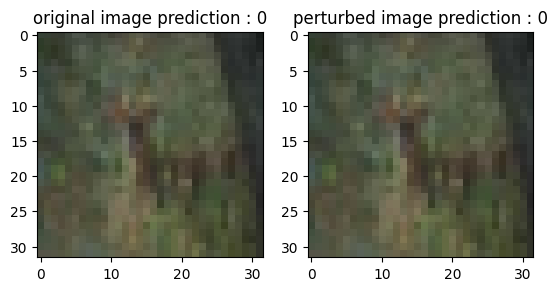

In [8]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

image = x_train[10]
c_ans = y_train[10]

image = np.array(image)
image = image /255.

image = image.reshape(1,32,32,3)

r_tot, loop_i, k_i, pert_image = DeepFool(image,f,grad_fs)

fig = plt.figure()

orig_pred = np.argmax(f(image))
deepfool_pred = np.argmax(f(pert_image))

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(image.reshape(32,32,3))
ax1.set_title('original image ' + 'prediction : ' + str(orig_pred))

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(pert_image.reshape(32,32,3))
ax2.set_title('perturbed image '+ 'prediction : ' + str(deepfool_pred))

plt.show()